In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

2023-11-08 11:32:29.340032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 11:32:29.907147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-08 11:32:56.799101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 11:32:56.877117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 11:32:56.877366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
IMAGE_SHAPE = (5, 127, 127)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/temp/127x127/5x127x127_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/temp/127x127/5x127x127_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/temp/127x127/5x127x127_testing.hdf5'

In [6]:
# param_names = []
# for i in ['g', 'r', 'i', 'z', 'y']:
#     for j in ['cmodel_mag', 'isophotal_area', 'half_light_radius', 'major_axis', 'minor_axis', 'ellipticity', 'sersic_index', 'peak_surface_brightness']:
#         param_names.append(i + '_' + j)
# v17

param_names = []
for i in ['g', 'r', 'i', 'z', 'y']:
    for j in ['cmodel_mag']:
        param_names.append(i + '_' + j)
        # v19

In [7]:
param_names

['g_cmodel_mag',
 'r_cmodel_mag',
 'i_cmodel_mag',
 'z_cmodel_mag',
 'y_cmodel_mag']

In [8]:
gen_args = {
    'image_key': 'image',
    'numerical_keys': param_names,
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': hparams['batch_size'],
    'shuffle': False}

In [9]:
train_gen = HDF5DataGenerator(TRAIN_PATH, mode='train', **gen_args)
val_gen = HDF5DataGenerator(VAL_PATH, mode='train', **gen_args)
test_gen = HDF5DataGenerator(TEST_PATH, mode='test', **gen_args)

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_cnn = Input(shape=(5,127,127))
input_nn = Input(shape=(len(param_names),)) # don't forget to change this

# CNN
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = GlobalMaxPooling2D(data_format='channels_first')(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

# NN
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)

# Concat & Output
concat = Concatenate()([dense3, hidden6])
output = Dense(1)(concat)
model = Model(inputs=[input_cnn, input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 127, 127  1472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 63, 63)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_combined_with_5pool_v25'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=20, shuffle=True, verbose=1, validation_data=val_gen)

Epoch 1/20


2023-11-08 11:33:48.314651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-08 11:33:50.069228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-08 11:33:50.083124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-08 11:33:50.196728: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 11:33:50.698701: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc350b1a980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 11:33:50.698725: I tensorflo

800/800 [==============================] - ETA: 0s - loss: 0.2722 - mse: 0.2663

2023-11-08 11:42:13.481306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


800/800 [==============================] - 608s 753ms/step - loss: 0.2722 - mse: 0.2663 - val_loss: 0.2090 - val_mse: 0.1637
Epoch 2/20
800/800 [==============================] - 658s 822ms/step - loss: 0.1983 - mse: 0.1237 - val_loss: 0.1801 - val_mse: 0.1014
Epoch 3/20
800/800 [==============================] - 785s 982ms/step - loss: 0.1788 - mse: 0.1102 - val_loss: 0.1566 - val_mse: 0.0948
Epoch 4/20
800/800 [==============================] - 848s 1s/step - loss: 0.1580 - mse: 0.1029 - val_loss: 0.1402 - val_mse: 0.0928
Epoch 5/20
800/800 [==============================] - 919s 1s/step - loss: 0.1344 - mse: 0.0952 - val_loss: 0.1360 - val_mse: 0.0905
Epoch 6/20
800/800 [==============================] - 972s 1s/step - loss: 0.1247 - mse: 0.0912 - val_loss: 0.1108 - val_mse: 0.0854
Epoch 7/20
800/800 [==============================] - 999s 1s/step - loss: 0.1111 - mse: 0.0862 - val_loss: 0.1153 - val_mse: 0.0828
Epoch 8/20
800/800 [==============================] - 956s 1s/step - lo

Exception ignored in: <function UniquePtr.__del__ at 0x7fc936abcb80>
Traceback (most recent call last):
  File "/home/billyli/.local/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [16]:
# might take too much memory, use PCA on morphology

In [17]:
model.load_weights(checkpoint_filepath)

In [16]:
pred = model.predict(test_gen)

2023-11-08 14:47:18.151603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


160/160 [==============================] - 187s 1s/step


In [18]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

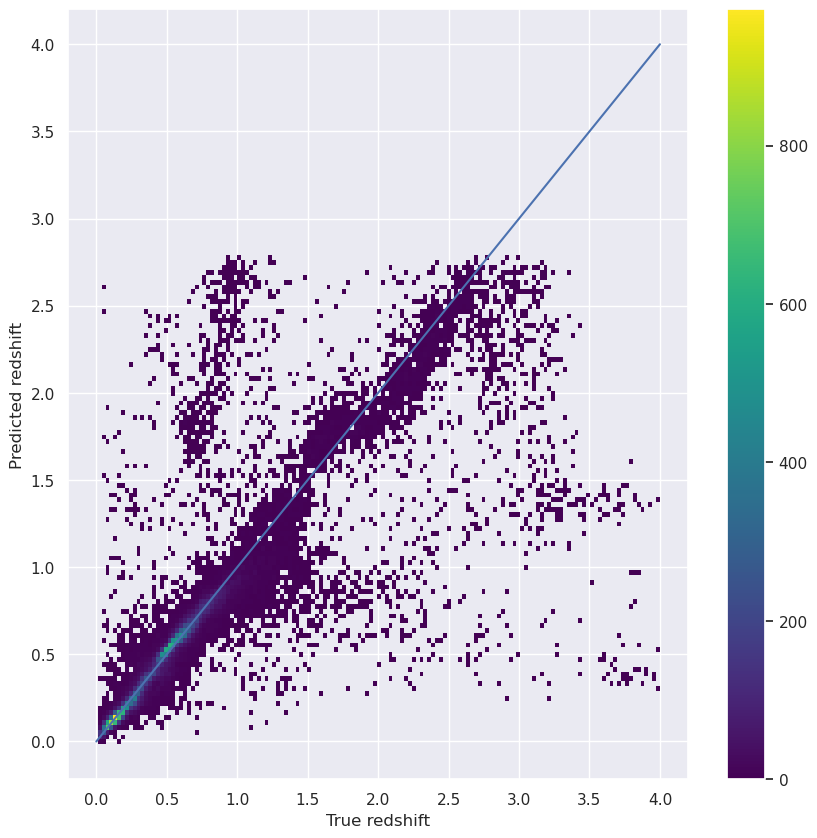

In [19]:
plot_predictions(np.ravel(pred), y_test)

In [21]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [22]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.055949,-0.002591,-0.00255,0.019724,0.016768,0.14183,0.035847,0.049169


In [23]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)